In [50]:
import numpy as np
import pandas as pd
import os 
import sys
import time
import matplotlib.pyplot as plt

# 벤다이어그램용
%matplotlib inline
import venn

In [51]:
class DataPreProcess:
    
    def __init__(self, region):
        
        self.path = os.getcwd()
        self.path = os.path.dirname(self.path)
        self.path = os.path.dirname(self.path)
        self.path= self.path + f'\\region\\{region}' #'\\region\\{}'.format(region) 
        self.region = region

    def makeDir(self):
        self.newPath = os.path.join(f'{self.path}\\PreprocessData') 
         
        if not os.path.exists(self.newPath):
            os.makedirs(os.path.join(f'{self.path}\\PreprocessData'))
        else:
            print('이미 존재합니다.')
        
        # 0_ 은 파일리스트 뽑을 때 commonPatientID 디렉토리를 맨 앞에 두기 위해서 해놓음.
    
    def dataSet(self):
        #filelist 부분을 합침
        self.fileList = os.listdir(self.path)[1:] 
        file_list = []
        for filename in self.fileList:
            # 파일명이 문자열을 포함하는지 확인
            if self.region in filename:
                file_list.append(filename)
        self.fileList = file_list
        self.dataDict = {}
        for i in self.fileList:
            self.dataDict[i] = pd.read_csv(self.path+'\\{}'.format(i), encoding = 'utf-16', index_col = 0)
        print('All files are added')
        return self.dataDict
    
    # Tmedication에는 환자정보와 시간이 없어서 만들기위해 TMedicalRecord와 MedicalRecordID를 key로서 사용하여 연결
    def Tmedication(self):
        
        #2024 버전의 데이터에 맞춰 변경
        temp = self.dataDict[f'{self.region}_tmedicalrecord.csv'][['MedicalRecordID','PatientID']]

        
        #저장하는 형식으로 코드 수정
        self.dataDict['{}_tmedication.csv'.format(self.region)] = \
            pd.merge(temp,self.dataDict['{}_tmedication.csv'.format(self.region)], how = 'inner', on = 'MedicalRecordID')
        return self.dataDict['{}_tmedication.csv'.format(self.region)]

        
        
    def patientChartNo(self):
        self.dataDict[f'{self.region}_tpatientpersonal.csv'] = \
        self.dataDict[f'{self.region}_tpatientpersonal.csv'].loc[self.dataDict[f'{self.region}_tpatientpersonal.csv']['PatientChartNo'].notnull()]

    def countUniquePatientID(self):
        for i in self.dataDict.keys():
            sheetPatientIDSet = self.dataDict[i]['PatientID']
            print(f'{i} sheetPatientIDSet,{len(sheetPatientIDSet)}')
            sheetPatientIDSet = set(self.dataDict[i]['PatientID'])
            print(f'{i} sheetPatientIDSet,{len(sheetPatientIDSet)}')

    def vennDiagram(self):
        self.inbodySet        = set(self.dataDict['{}_tinbodyadditionaldata.csv'.format(self.region)]['PatientID'])
        self.privateSet       = set(self.dataDict[f'{self.region}_tpatientpersonal.csv']['PatientID'])
        self.medicationSet    = set(self.dataDict['{}_tmedication.csv'.format(self.region)]['PatientID'])
        self.medicalRecordSet = set(self.dataDict['{}_tmedicalrecord.csv'.format(self.region)]['PatientID'])
        self.vitalTempSet     = set(self.dataDict['{}_tpatientvitaltemp.csv'.format(self.region)]['PatientID'])
    
        self.labels = venn.get_labels([self.inbodySet,self.privateSet,self.medicationSet,self.medicalRecordSet,self.vitalTempSet])
        # augument 로 fill을 안써도 되는구나 ( pilot 보면 여기에 써놓음)
        plt.figure(figsize=(12,8))
        fig,ax = venn.venn5(self.labels,names = ['inbody','private','medication','medicalRecord','vitalTemp'])
        plt.title(f'{self.region}')
        plt.show()
        plt.close()

    def makeInbody(self):
        #파일 리스트를 만들고 문제가 있는 파일 제거
        #impedence와 measurement는 plat작업이 필요
        #obestity는 인덱스 에러(?)
        inbody_file_names = self.fileList[0:14]
        inbody_file_names.remove(f'{self.region}_tinbodyimpedence.csv')
        inbody_file_names.remove(f'{self.region}_tinbodymeasurement.csv')
        inbody_file_names.remove(f'{self.region}_tinbodyobesitydiagnosis.csv')

        for i, name in enumerate(inbody_file_names):
            df = self.dataDict[name]
            df['MeasureDate'] = pd.to_datetime(df['MeasureDate'], format='%Y%m%d%H%M%S')
            df = df.sort_values(by=['PatientID', 'MeasureDate']).reset_index(drop=True)
            print()
            print(i, name, len(df))
            if i == 0 :
                inbody_total_df = df
        
            else:
                df.drop(columns=['ReadingID'], inplace=True)
                df_columns = set(df.columns)
                total_columns = set(inbody_total_df.columns)
                common_feature = list(df_columns & total_columns)
                print(common_feature)
                inbody_total_df =pd.merge(inbody_total_df, df, on = common_feature)
                print(len(inbody_total_df))
        print(inbody_total_df.shape)
        print(inbody_total_df.head())

        #measurment part
        df = self.dataDict[f'{self.region}_tinbodymeasurement.csv']
        df['MeasureDate'] = pd.to_datetime(df['MeasureDate'], format='%Y%m%d%H%M%S')
        df = df.sort_values(by=['PatientID', 'MeasureDate']).reset_index(drop=True)
        df = df.iloc[:,1:12]

        #measurment feature 생성
        feature_names = df.columns[3:]
        neck_feature_names = ['neck_'+ name for name in feature_names]
        chest_feature_names = ['chest_'+ name for name in feature_names]
        abdomen_feature_names = ['abdomen_'+ name for name in feature_names]
        hip_feature_names = ['hip_'+ name for name in feature_names]
        Larm_feature_names = ['Larm_'+ name for name in feature_names]
        Rarm_feature_names = ['Rarm_'+ name for name in feature_names]
        Lleg_feature_names = ['Lleg_'+ name for name in feature_names]
        Rleg_feature_names = ['Rleg_'+ name for name in feature_names]

        for i in range(len(df)):
            if i % 8 == 0:
                imsi_dict = {'PatientID': df.loc[0,'PatientID'], 'MeasureDate' : df.loc[0,'MeasureDate']}
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {neck_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 1:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {chest_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 2:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {abdomen_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 3:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {hip_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 4:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {Larm_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 5:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {Rarm_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 6:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {Lleg_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 7:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {Rleg_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
                
            if i < 7:
                continue
            elif i == 7:
                mesurment_df = pd.DataFrame(imsi_dict)
            elif i % 8 == 7:
                imsi_df = pd.DataFrame(imsi_dict)
                mesurment_df = pd.concat([mesurment_df, imsi_df])
            mesurment_df.reset_index(inplace=True, drop=True)
            
        print(mesurment_df.shape)
        print(mesurment_df.head())

        #병합
        inbody_total_df =pd.concat([inbody_total_df,mesurment_df.iloc[:,2:]], axis =1)

        #impedence part
        df = self.dataDict[f'{self.region}_tinbodyimpedence.csv']
        df['MeasureDate'] = pd.to_datetime(df['MeasureDate'], format='%Y%m%d%H%M%S')
        df = df.sort_values(by=['PatientID', 'MeasureDate']).reset_index(drop=True)

        #freq 기준으로 feature 만듬
        feature_names = df.columns[4:9]
        feature_names1 = ['1_'+ name for name in feature_names]
        feature_names5 = ['5_'+ name for name in feature_names]
        feature_names50 = ['50_'+ name for name in feature_names]
        feature_names250 = ['250_'+ name for name in feature_names]
        feature_names500 = ['500_'+ name for name in feature_names]
        feature_names1000 = ['1000_'+ name for name in feature_names]

        for i in range(len(df)):
            if i % 6 == 0:
                imsi_dict = {'PatientID': df.loc[0,'PatientID'], 'MeasureDate' : df.loc[0,'MeasureDate']}
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names1[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 1:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names5[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 2:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names50[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 3:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names250[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 4:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names500[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 5:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names1000[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
                
            if i < 5:
                continue
            elif i == 5:
                impedence_df = pd.DataFrame(imsi_dict)
            elif i % 6 == 5:
                imsi_df = pd.DataFrame(imsi_dict)
                impedence_df = pd.concat([impedence_df, imsi_df])
        
        impedence_df.reset_index(inplace=True, drop=True)
        print(impedence_df.shape)
        print(impedence_df.head())
        inbody_total_df = pd.concat([inbody_total_df, impedence_df.iloc[:,2:]], axis = 1)

        #obesitydiagnosis part
        df = self.dataDict[f'{self.region}_tinbodyobesitydiagnosis.csv']
        df['MeasureDate'] = pd.to_datetime(df['MeasureDate'], format='%Y%m%d%H%M%S')
        df = df.sort_values(by=['PatientID', 'MeasureDate']).reset_index(drop=True)
        df.drop(columns=['ReadingID'], inplace=True)
        df = df.drop('PSMM', axis=1)
        df = df.drop('PWeight', axis=1)
        df = df.drop('Weight', axis=1)
        df = df.drop('ReadingID_ORG', axis=1)

        inbody_total_df = pd.merge(inbody_total_df, df, on = ['MeasureDate', 'PatientID'])
        print(inbody_total_df.shape)
        print(inbody_total_df.head())

        self.inbody_total_df = inbody_total_df
        return(self.inbody_total_df)


    def saveDataFrame(self):
        self.inbody_total_df.to_csv(f'{self.newPath}\\{self.region}_inbody_total.csv', index=False)
        self.inbody_total_df.to_excel(f'{self.newPath}\\{self.region}_inbody_total.xlsx', index=False)
        
                
                

In [54]:
region = DataPreProcess(region = 'bucheon')
region.dataSet()

C:\Users\howsr\AppData\Local\Temp\ipykernel_18572\1165393116.py:32: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataDict[i] = pd.read_csv(self.path+'\\{}'.format(i), encoding = 'utf-16', index_col = 0)
C:\Users\howsr\AppData\Local\Temp\ipykernel_18572\1165393116.py:32: DtypeWarning: Columns (8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataDict[i] = pd.read_csv(self.path+'\\{}'.format(i), encoding = 'utf-16', index_col = 0)


All files are added


{'bucheon_tinbodyadditionaldata.csv':        ReadingID  PatientID     MeasureDate  ObesityDegree   BCM   BMR   BMC  \
 0         314586     191196  20221107100315             91  30.9  1403  2.83   
 1         314591     134236  20221107100403            135  28.8  1324  2.51   
 2         314596       1426  20221107100718            161  28.6  1325  2.67   
 3         314601     181081  20221107102005            101  25.5  1222  2.44   
 4         314606     161799  20221107102503            167  25.8  1233  2.16   
 ...          ...        ...             ...            ...   ...   ...   ...   
 12858     381781     240091  20240514183832            120  39.8  1686  3.47   
 12859     381786     243111  20240514185357            115  25.5  1231  2.51   
 12860     381791     231996  20240514185735            138  26.2  1244  2.45   
 12861     381796     242865  20240514190048            129  30.0  1364  2.68   
 12862     381801     243046  20240514193429            171  35.5  1538 

In [55]:
medrec_df = region.dataDict['bucheon_tmedicalrecord.csv']
medication_df =region.dataDict['bucheon_tmedication.csv']

In [56]:
medrec_df['ConsultTime'] = pd.to_datetime(medrec_df['ConsultTime'], format='%Y%m%d%H%M%S')
medrec_df = medrec_df.sort_values(by=['PatientID', 'ConsultTime']).reset_index(drop=True)

In [58]:
medrec_df[medrec_df['PatientID'] == 1367]

,MedicalRecordID,PatientID,ScheduleID,ConsultTime,ConsultNote,ProgressNote,Summary,RequestI,RequestII,TreatmentCat,...,TaxableAmt,TDiscountAmt,PregGrantAmt,MedicalRecordID_ORG,CancerNo,ExceptClaim,InfantFlag,Ins100Amt,LtClaimAmt,LtChargeAmt
497,1103186,1367,1370326,2023-09-20 16:15:00,NaN,#비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...,NaN,109.0,NaN,0,...,0,0,0,NaN,0,0,0,0,0,0
498,1135570,1367,1410690,2023-11-27 11:55:00,NaN,# 비만(전화접수)\n\n★3개월미만 미내원 의료진 확인사항 \n현재체중 : 65k...,NaN,NaN,NaN,0,...,0,0,0,NaN,0,0,0,0,0,0


In [59]:
medication_group= medication_df.groupby('MedicalRecordID')

In [60]:
medication_df['MedicineName'].unique()

array(['GambiTab-U_1통*3#405', '비움정1통*2', '팻아웃 정1통*1',
       'GambiTab-D5_1통*3#405', 'GambiTab-D6_1통*3#405',
       'GambiTab-M_1통*3#405', '부스터 정 1통*2', '비움정1통*1',
       'GambiTab-D4_1통*3#405', 'GambiTab-U+_1통*3#405',
       'GambiTab-Y플러스_1통*3', 'GambiTab-D2X_1통*3#405',
       'GambiTab-Y플러스_1통*1', '팻아웃 플러스1통*2', 'GambiTab-G_1통*3#405',
       'GambiTab-D4_1통*1#135', '팻아웃 플러스1통*1', 'GambiTab-S_1통*3#405',
       '팻아웃 정1통*3', '팻아웃 정1통*2', 'GambiTab-A_1통*3#405',
       'GambiX-U_1박스*3#135', '붓기아웃1통*1', '부스터 정 1통*3',
       'GambiTab-D6_1통*6#810', '붓기아웃1통*2', '팻아웃 플러스1통*3',
       'GambiTab-D3X_1통*1#135', 'GambiTab-D3_1통*3#405',
       'GambiX-S_1박스*3#135', 'GambiTab-D2X_1통*1#135',
       'GambiTab-D6_1통*1#135', '팻아웃 플러스1통*6', '붓기아웃1통*3', '비움정1통*3',
       'GambiTab-D3_1통*1#135', 'GambiTab-T_1통*3#405', '부스터 정 1통*1',
       'GambiTab-D3X_1통*3#405', '팻아웃 정1통*5', 'GambiTab-D4_1통*6#810',
       '팻아웃 정1통*4', '팻아웃 정1통*6', 'GambiTab-U_1통*2#270',
       'GambiTab-D5_1통*1#135', '경옥고 스틱 1박스 *1', '팻

{'whiskers': [<matplotlib.lines.Line2D at 0x13d2d5ae710>,
 'caps': [<matplotlib.lines.Line2D at 0x13d2d5b7490>,
 'boxes': [<matplotlib.lines.Line2D at 0x13d2d5ae3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x13d2d5b5110>],
 'fliers': [<matplotlib.lines.Line2D at 0x13d2d5b5b10>],
 'means': []}

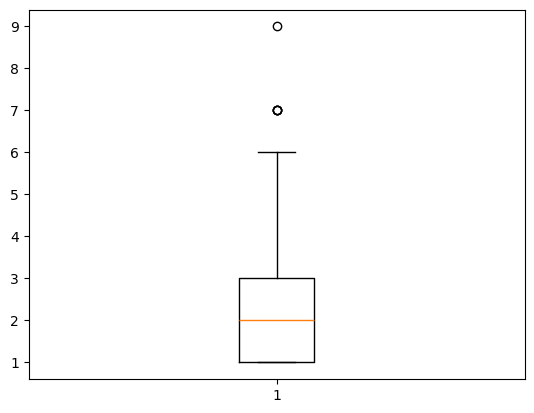

In [61]:
plt.boxplot(medication_group.size())

In [62]:
medication_group.groups

{865735: [1], 865740: [0, 98], 865741: [10, 164], 865746: [2, 3], 865751: [72, 73], 865756: [6, 7], 865760: [17, 18], 865761: [31, 32], 865766: [227, 228, 229], 865770: [4, 5], 865771: [34, 50], 865775: [77, 78, 79], 865780: [174], 865785: [9], 865786: [11, 12], 865795: [8, 15, 16, 54], 865800: [13, 14], 865805: [21, 22], 865806: [19], 865816: [28, 29], 865821: [25, 26, 27], 865825: [20], 865826: [23, 24], 865836: [30], 865845: [40, 41], 865850: [186], 865851: [33], 865866: [46], 865870: [38, 39], 865871: [47], 865881: [35, 36, 37], 865886: [42], 865891: [48, 49], 865900: [165, 166, 167], 865911: [43, 44], 865915: [45], 865920: [56, 57], 865925: [58], 865930: [53], 865935: [68, 69], 865940: [101], 865950: [64, 65], 865955: [51, 52], 865956: [55, 112], 865965: [59, 162], 865966: [60], 865985: [153], 865986: [61], 865991: [62, 63], 865996: [66, 67], 866000: [70, 71], 866005: [74], 866010: [75, 76], 866011: [85, 86, 96], 866016: [80, 81, 82], 866021: [83], 866026: [102], 866031: [87, 88],

In [63]:
MedicineName_vec = medication_group.apply(lambda x: list(x['MedicineName']))

In [64]:
code_vec = medication_group.apply(lambda x: list(x['MedicineCode']))

In [65]:
Memo_vec = medication_group.apply(lambda x: list(x['Memo']))

In [66]:
combine_df = pd.concat([MedicineName_vec,code_vec,Memo_vec], axis =1)

In [67]:
combine_df

,0,1,2
MedicalRecordID,,,
865735,[비움정1통*2],[1831.0],[1]
865740,"[GambiTab-U_1통*3#405, 팻아웃 정1통*1]","[2685.0, 1987.0]","[2-2, 1]"
865741,"[팻아웃 정1통*1, GambiTab-D2X_1통*3#405]","[1987.0, 3145.0]","[1, 2-2]"
865746,"[팻아웃 정1통*1, GambiTab-U_1통*3#405]","[1987.0, 2685.0]","[1, 2-1]"
865751,"[GambiTab-M_1통*3#405, 팻아웃 플러스1통*2]","[2670.0, 2855.0]","[2-2, 1]"
...,...,...,...
1201196,"[GambiTab-Dx145_1통*6#810, 하루비움정1통*1, 팻아웃 정1통*2]","[3495.0, 3366.0, 1992.0]","[2-1,2, 1, 1]"
1201205,"[GambiTab-Men_1통*6#810, 팻아웃Men정1통*2, 하루비움정1통*1]","[3690.0, 3675.0, 3366.0]","[2-1,2, 1, 1]"
1201206,"[GambiTab-Dx128_1통*6#810, 팻아웃 정1통*2, 하루비움정1통*1]","[3491.0, 1992.0, 3366.0]","[2-1,2, 1, 1]"


In [68]:
medication_df.columns

Index(['MedicationID', 'MedicalRecordID', 'MedicineCode', 'MedicineName',
       'NoApps', 'TotalApps', 'NoDays', 'Chup', 'Pack', 'Dose', 'Weight',
       'Price', 'Additional', 'Category1', 'Category2', 'Memo', 'Confirm',
       'PrescMemo', 'PrescDeliverMemo', 'MedicationID_ORG', 'DoctorID',
       'LicNo', 'OrderyCheck'],
      dtype='object')

In [69]:
imsi_df = medication_group.first()
imsi_df.columns

Index(['MedicationID', 'MedicineCode', 'MedicineName', 'NoApps', 'TotalApps',
       'NoDays', 'Chup', 'Pack', 'Dose', 'Weight', 'Price', 'Additional',
       'Category1', 'Category2', 'Memo', 'Confirm', 'PrescMemo',
       'PrescDeliverMemo', 'MedicationID_ORG', 'DoctorID', 'LicNo',
       'OrderyCheck'],
      dtype='object')

In [70]:
imsi_df.drop('MedicineCode', axis = 1, inplace = True)
imsi_df.drop('MedicineName', axis = 1, inplace = True)
imsi_df.drop('Memo', axis = 1, inplace = True)

In [71]:
imsi_df =pd.merge(combine_df, imsi_df, on ='MedicalRecordID')

In [72]:
imsi_df=imsi_df.reset_index()

In [73]:
imsi_df.columns

Index([ 'MedicalRecordID',                  0,                  1,
                        2,     'MedicationID',           'NoApps',
              'TotalApps',           'NoDays',             'Chup',
                   'Pack',             'Dose',           'Weight',
                  'Price',       'Additional',        'Category1',
              'Category2',          'Confirm',        'PrescMemo',
       'PrescDeliverMemo', 'MedicationID_ORG',         'DoctorID',
                  'LicNo',      'OrderyCheck'],
      dtype='object')

In [74]:
medication_df = imsi_df.rename(columns={0: 'MedicineName',1:'MedicineCode', 2:'Memo'})

In [26]:
len(medication_df)

79649

In [27]:
medical_df = pd.merge(medrec_df, medication_df, on = 'MedicalRecordID', how= 'outer')

In [35]:
notno_medicine=medical_df[medical_df['MedicineName'].notna() ]

In [30]:
group = medical_df.groupby('PatientID')

In [49]:
group.count()['MedicineName'][group.count()['MedicineName'] != 0].count()

29068

In [36]:
group2notno_medicine.groupby('PatientID')